# Token Alignment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from genparse import CFG, FST, EPSILON, Float, CFGLM, add_EOS, prefix_transducer
from genparse.cfglm import locally_normalize
from genparse.util import LarkStuff, hf_tokenizer
from arsenal import iterview, timeit
from collections import Counter
#from mockup import about, bpe2term_approx, show_grammar
#from original_prefix_grammar import PrefixGrammar
from genparse.inference import TraceSWOR

In [3]:
def pcfg_check(cfg):
    chart = cfg.agenda()
    if all((0 <= v <= 1.000001) for v in chart.values()):
        print(colors.mark(True), 'PCFG')
    else:
        print(colors.mark(False), 'PCFG', chart.__str__(style_value=lambda k, v: (colors.light.red % v) if v > 1.000001 or v < 0 else v))

In [4]:
lark_stuff = LarkStuff(r"""

start: NAME

NAME: /(a|b)*c/

""")

cfg = lark_stuff.convert().renumber()
c2t = lark_stuff.transducer(ignore='', decay=.1).renumber.trim
cfg_t = (c2t @ cfg).trim()

In [5]:
cfg

Grammar {
  1.0: 0 → NAME
}

In [6]:
#locally_normalize(cfg_t).trim()

In [7]:
#locally_normalize(cfg_t).prefix_grammar.cnf

In [8]:
#c2t

In [9]:
foo = lark_stuff.char_cfg(decay=.1)

In [10]:
foo

Grammar {
  1.0: 0 → NAME
  1: NAME → ('NAME', 0)
  0.1: ('NAME', 1) → 
  0.03333333333333333: ('NAME', 0) → a ('NAME', 0)
  0.03333333333333333: ('NAME', 0) → b ('NAME', 0)
  0.03333333333333333: ('NAME', 0) → c ('NAME', 1)
}

In [11]:
foo.cnf.language(3)

key,value
"('c',)",0.0033333333333333335
"('b', 'c')",0.00011111111111111112
"('b', 'b', 'c')",3.7037037037037037e-06
"('b', 'a', 'c')",3.7037037037037037e-06
"('a', 'c')",0.00011111111111111112
"('a', 'b', 'c')",3.7037037037037037e-06
"('a', 'a', 'c')",3.7037037037037037e-06


In [12]:
foo = locally_normalize(foo)
assert len(foo.trim()) > 0
pcfg_check(foo)

✔ PCFG


In [13]:
lm = CFGLM(add_EOS(foo))

In [14]:
trace = TraceSWOR()
for t in range(15):
    with trace:
        print(t, lm.sample(draw=trace))

0 ['c']
1 ['a', 'c']
2 ['b', 'c']
3 ['b', 'b', 'c']
4 ['b', 'a', 'c']
5 ['a', 'a', 'c']
6 ['a', 'b', 'c']
7 ['b', 'a', 'b', 'c']
8 ['b', 'b', 'a', 'c']
9 ['a', 'b', 'b', 'c']
10 ['a', 'b', 'a', 'c']
11 ['b', 'b', 'b', 'c']
12 ['b', 'a', 'a', 'c']
13 ['a', 'a', 'b', 'b', 'c']
14 ['a', 'a', 'a', 'c']


In [15]:
#for q in c2t.states:      
#    for (a,b), r, w in c2t.arcs(q):
#        print(f'--{a or "ε"}:{b or "ε"}/{w}-->', r)

https://aclanthology.org/P14-2102.pdf

We want to ensure that $p(x \mid y)$ is a valid probability distribution over $x$ for each $y$.

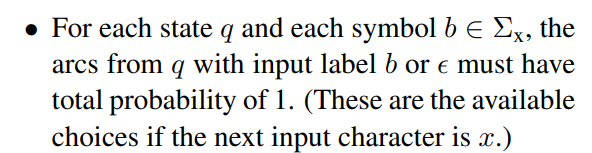

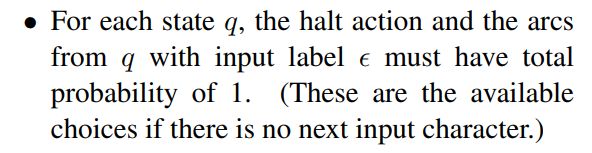

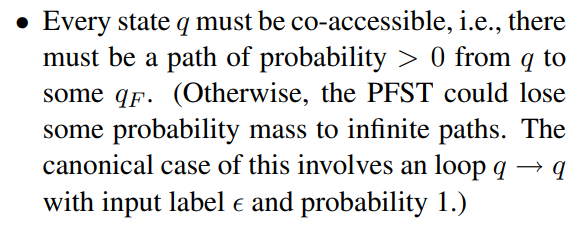

In [16]:
# (FST.from_string('aaacbbbc', Float) @ c2t).project(1).epsremove.trim

In [17]:
# for x, w in cfg.cnf.language(5).items():
#     print(w, x)
#     xx = (c2t @ FST.from_string(x, Float)).project(0).epsremove.trim
#     print(xx.total_weight())
#     display(xx)

In [18]:
#cfg_t.cnf.language(5)

In [19]:
#print(cfg_t.agenda().__str__(style_value=lambda k, v: (colors.light.red % v) if v > 1 or v < 0 else v))

In [20]:
#cfg.cnf.language(5)

In [21]:
#cfg_t.cnf.language(3)

In [22]:
#cfg_t.prefix_grammar.trim().cnf

In [23]:
#show_grammar(cfg_t.prefix_grammar.trim())

In [24]:
x = 'SELECT * FROM data'

In [25]:
# g = CFG.from_string("""

# 1: S -> a

# """, Float)

# t = FST(Float)
# t.add_I(0, 1)
# t.add_arc(0, ('a', ''), 1, 1)
# t.add_arc(1, ('', 'b'), 1, 0.5)
# t.add_F(1, 1)

# (g @ t).language(10)

In [30]:
lark_stuff = LarkStuff(r"""

start: "SELECT" " " NAME "X"

NAME: /b+/

""")

cfg = lark_stuff.convert().renumber()
c2t = lark_stuff.transducer(ignore='', decay=.9).renumber
cfg_t = (c2t @ cfg).trim()

#display(cfg_t)

#display(cfg_t.language(25))

#pg = locally_normalize(cfg_t.cnf).prefix_grammar.trim()
#pg = pg.cnf
#display(pg)

#print(cfg_t.V)
#pg = PrefixGrammar(cfg_t)
pg = cfg_t.prefix_grammar

pg('SELECT bbb')   # should be nonzero...

0.8862938119641267

In [32]:
#c2t

In [34]:
#c2t(None, ('NAME',)).epsremove.trim.total_weight()

In [36]:
#cfg_t.language(19)

In [37]:
#cfg_t.cnf.trim()

In [38]:
#locally_normalize(cfg_t.cnf).treesum()

In [39]:
#locally_normalize(cfg_t.cnf).trim()

In [40]:
#locally_normalize(cfg_t.cnf).prefix_grammar.trim()

## Lexing

In [41]:
lark_stuff = LarkStuff(r"""

start: "SELECT" WS STAR WS "FROM" WS NAME WS EOS

EOS: "</s>"
NAME: /[a-z]+/
STAR: "*"
WS: /[ ]/

""")

In [42]:
foo = lark_stuff.char_cfg(.5)

In [43]:
#foo['NAME'].trim().agenda()

In [44]:
#foo.agenda()

In [45]:
foo = locally_normalize(foo).trim()
assert len(foo) > 0

In [46]:
#foo

In [47]:
lm = CFGLM(add_EOS(foo))

In [48]:
trace = TraceSWOR()
for _ in range(15):
   print('mass=', trace.root.mass)
   with trace:
       print(lm.sample(draw=trace))

mass= 1.0
['S', 'E', 'L', 'E', 'C', 'T', ' ', '*', ' ', 'F', 'R', 'O', 'M', ' ', 'k', 'f', 'i', ' ', '<', '/', 's', '>']
mass= 0.9629903768294437
['S', 'E', 'L', 'E', 'C', 'T', ' ', '*', ' ', 'F', 'R', 'O', 'M', ' ', 'f', 'w', 'a', 'y', ' ', '<', '/', 's', '>']
mass= 0.9259807531832742
['S', 'E', 'L', 'E', 'C', 'T', ' ', '*', ' ', 'F', 'R', 'O', 'M', ' ', 't', 'k', ' ', '<', '/', 's', '>']
mass= 0.88897111978131
['S', 'E', 'L', 'E', 'C', 'T', ' ', '*', ' ', 'F', 'R', 'O', 'M', ' ', 'm', 'x', ' ', '<', '/', 's', '>']
mass= 0.8519614863793461
['S', 'E', 'L', 'E', 'C', 'T', ' ', '*', ' ', 'F', 'R', 'O', 'M', ' ', 'r', 'y', ' ', '<', '/', 's', '>']
mass= 0.814951852977382
['S', 'E', 'L', 'E', 'C', 'T', ' ', '*', ' ', 'F', 'R', 'O', 'M', ' ', 'c', ' ', '<', '/', 's', '>']
mass= 0.7772025652101627
['S', 'E', 'L', 'E', 'C', 'T', ' ', '*', ' ', 'F', 'R', 'O', 'M', ' ', 'p', ' ', '<', '/', 's', '>']
mass= 0.7394532774429434
['S', 'E', 'L', 'E', 'C', 'T', ' ', '*', ' ', 'F', 'R', 'O', 'M', ' ', 

In [49]:
cfg = lark_stuff.convert().renumber()

In [50]:
c2t = lark_stuff.transducer(ignore='', decay=.7); len(c2t.states)

25

In [51]:
#c2t

The `lark` library will only lex it one way because it has a deterministic semantics for prioritized lexing:

In [ ]:
list(lark_stuff.lex(x))

However, this string can lex many different ways:

In [ ]:
ambig = (FST.from_string(x, Float) @ c2t).trim.project(1).epsremove.trim.to_cfg().cnf.language(15)

In [ ]:
#ambig

It might be fine to allow ambiguous lexing because very few of the possibly lexing options will survive the parser.

In [ ]:
for y in ambig:
    v = cfg.prefix_weight(y)   # show all options with a nonzero prefix weight
    if v == 0: continue
    print(v, y)

In [ ]:
#((FST.from_string('SELECT', Float) @ c2t) @ P.T @ cfg).trim().cnf.language(15)

In [ ]:
#(P.T @ cfg).trim().cnf.language(100)

In [ ]:
cfg_t = (c2t.renumber @ cfg).trim()

In [ ]:
#cfg_t.cnf.trim().language(13)

In [ ]:
#cfg_t.V

In [ ]:
#cfg_t.agenda(maxiter=100)

In [ ]:
#cfg_t.prefix_grammar('SEL')   # XXX: we what to run this, but the composition with c2t results in divergence!

In [ ]:
#chart = cfg_t.agenda()
#chart

In [ ]:
#chart = cfg_t.agenda(maxiter=100)

In [ ]:
#for block in cfg_t.dependency_graph().blocks():
#    if any( chart[y] > 1.001 for y in  block ):
#        print(block, [chart[y] for y in block])

In [ ]:
#show_grammar(cfg_t)

In [ ]:
#cfg_t.agenda()

In [ ]:
#cfg_t.cnf.trim().prefix_grammar.cnf('SELECT * FR')

In [ ]:
cfg_t.trim().cnf('SELECT * FROM data </s>')

In [ ]:
pg = locally_normalize(cfg_t.cnf.trim()).prefix_grammar.trim()
pg = pg.cnf

In [ ]:
pg('SEL')

In [ ]:
pg('SELECT *')

In [ ]:
lm = CFGLM(add_EOS(locally_normalize(cfg_t.cnf.trim())))

In [ ]:
for _ in range(10):
    print(''.join(lm.sample()))

In [ ]:
lm.p_next('SELECT * FROM ')

In [ ]:
#cfg_t.cnf.language(13)

In [ ]:
cfg_t('SELECT * FROM data </s>')

In [ ]:
#lm = CFGLM(cfg_t)

## BPE Basics

In [ ]:
hf_tk = hf_tokenizer()
tokenizer = hf_tk.tokenizer

In [ ]:
b2c = hf_tk.fst
len(b2c.states)

In [ ]:
x = 'SELECT * FROM data'
b = tokenizer.encode(x)
b

In [ ]:
[tokenizer.decode([bb]) for bb in b]

In [ ]:
#FST.from_pairs(hf_tk.pairs[1000:1020], Float).star().epsremove.trim

In [ ]:
with timeit('composition'):
    c = FST.from_string(tuple(b), Float) @ b2c
about(c)

In [ ]:
c.trim

We can build this "transducer" more efficiently

In [ ]:
t = bpe2term_approx(tokenizer, tokenizer.encode(x)).epsremove.trim
t

## BPE Ambiguity

In [ ]:
with timeit('composition'):
    bs = b2c @ FST.from_string(x, Float)
with timeit('trim'):
    bs.trim
about(bs)

In [ ]:
#bs.trim

The automaton below describes all the BPE sequences that generate the string `x`:

In [ ]:
bs.trim.project(0).epsremove.trim

To see all the BPE sequences that generate `x` run the cell below:

In [ ]:
#for y in bs.trim.project(0).epsremove.trim.to_cfg().language(10):
#    print(tokenizer.decode(y), y)

In [ ]:
#show_grammar(cfg_t, chart)

In [ ]:
#cfg_t

## BPE-to-Terminal

In [ ]:
#FST.from_string(tuple(b), Float) @ b2c

In [ ]:
#t.to_cfg().cnf.language(50)

In [ ]:
#e.trim.renumber.to_cfg().trim().cnf.language(55)

In [ ]:
#e.trim.renumber.project(0).epsremove.trim

In [ ]:
#e.trim.renumber.project(0).epsremove.trim.to_cfg().trim().cnf.language(6)

In [ ]:
#tmp = c2t('SELECT', None).trim.epsremove.trim
#tmp

In [ ]:
#tmp = c2t('SELECT\n\t\r FROM 1 2', None).trim.epsremove.trim#.min
#tmp

In [ ]:
#tmp = c2t('SELECT\nFROM', ('KEYWORD', 'KEYWORD'))
#tmp

In [ ]:
# random.seed(8675309)
# bpe_small = random.sample(T, 10)
# b2c_small = bpe_wfst(bpe_small).renumber
# len(b2c_small.states)

In [ ]:
#bpe_small

In [ ]:
#b2c_small

In [ ]:
#c = FST.from_string('zon ankles Turtles purple', Float).renumber

In [ ]:
#len((b2c_small @ c).states), len((b2c_small @ c).trim.states)

In [ ]:
#(b2c_small @ c).trim

In [ ]:
# N = lambda x: abs(hash(x)) % 3
# A = lambda x: abs(hash(x)) % 2
# B = lambda x: abs(hash(x)) % 7

# bbb = b2c_small.coarsen(N, A, B)
# ccc = c.coarsen(N = lambda x: abs(hash(x)) % 5, A = B, B = B)

In [ ]:
#bbb

In [ ]:
#ccc

In [ ]:
#monster = b2c @ c2t

In [ ]:
#len(monster.states), len(monster.trim.states)

In [ ]:
#monster_baby = FST.from_string((5188,), Float).renumber @ monster 

In [ ]:
#len(monster_baby.states), len(monster_baby.trim.states)

In [ ]:
#c = FST.from_string(x, Float).renumber
#c

In [ ]:
#query = b2c @ c

In [ ]:
#query.trim

In [ ]:
#len(query.states), len(query.trim.states)

In [ ]:
#terminals = (c @ lark_stuff.transducer()).trim
#terminals

In [ ]:
#list(lark_stuff.lex(x))

In [ ]:
#bpe2terminal = query.trim @ terminals

In [ ]:
#len(bpe2terminal.states), len(bpe2terminal.trim.states)

In [ ]:
#bpe2terminal.trim